WORK FLOW
    ///1. Build a classifier to identify fake news articles.
    ///2. Validate the model using the validation dataset.
    ///3. Save the trained model for future use.
    ///4. Test the model on unseen data to evaluate its performance.


## Load data and explore


In [ ]:
# Block 0: Libraries.

#System
import os                # File and directory operations
import re                # Regular expressions

# Block 1: Load and explore dataset
**  Load the dataset and perform initial exploration to understand its structure and content. **
    5 Columns: Label, Title, Text, Subject, Date
    Number of rows: 39942
**  Analyze the distribution of classes (fake vs real news)(Balance of dataset) **
**  Labels distribution this distribution shows that the dataset is relatively balanced, with a slight predominance of real news articles. also 1 as true and 0 as false are commonly used to represent "True" or "false" cases in binary classification tasks.
    Fake: 0 -   19943
    Real: 1 - 19999
** Subjects distribution: **(important for understanding the context of the articles for model training)
    Politicalnews, Politics, worldnews, News, Left-news, Government news.
    Unbalanced subjects distribution with Politics news being the most frequent.
    cross validation to see relatition between subjects and labels.
    

In [ ]:
# Block 1: Load and explore dataset
# Load dataset
import pandas as pd
df = pd.read_csv('/Users/nazb/VSCode101/project-nlp-challenge/dataset/data.csv')

# Display first few rows of the dataset
print(df.head())

# Display dataset general information
print( f'\n Number of columns and rows:' ,df.shape)
print (df.info())
print(f'\n Missing values per column:' ,df.isnull().sum())
# Display the distribution of classes
print(f'\n Class distribution:' ,df["label"].value_counts())
print(f'\n Class distribution percentage: ', df['label'].value_counts(normalize=True) * 100)
# Display the distribution of subjects
print(f'\n Subject distribution:' ,df["subject"].value_counts())
# Cross count of subject vs label
print(f"Cross count of subject and label:\n{df.groupby(['subject','label']).size().unstack(fill_value=0)}\n")
print(f"Percentage of fake/real per subject:\n{df.groupby(['subject','label']).size().unstack(fill_value=0).div(df.groupby(['subject','label']).size().unstack(fill_value=0).sum(axis=1), axis=0) * 100}")



   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3      1  FBI Russia probe helped by Australian diplomat...   
4      1  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

 Number of columns and rows: (39942, 5)
<class 'pandas.

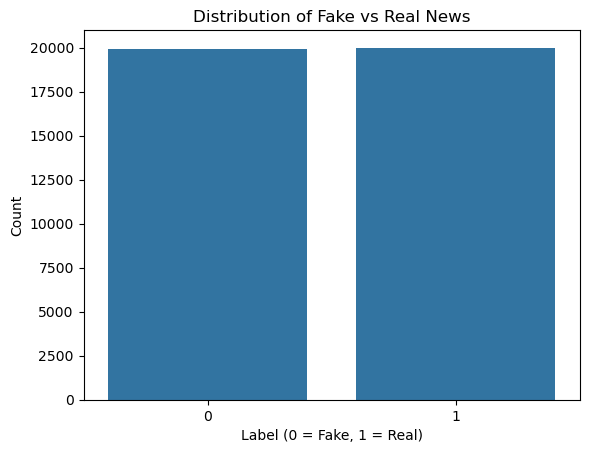

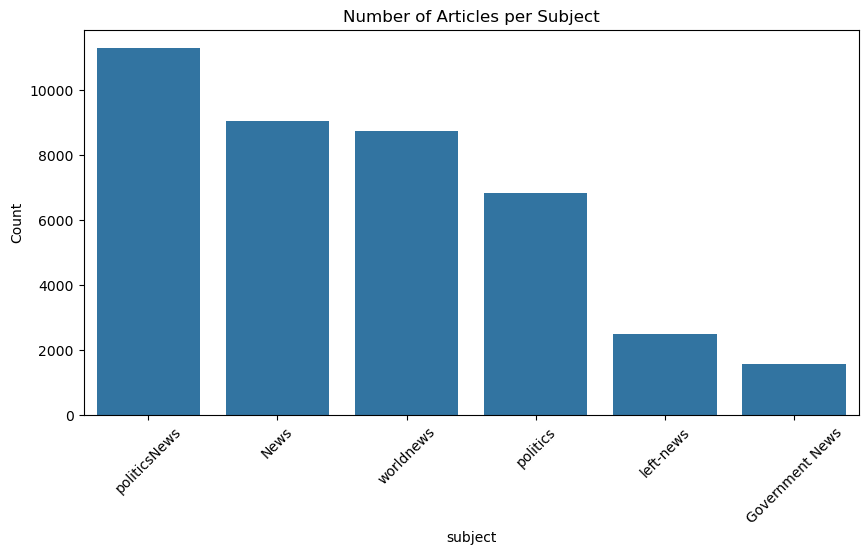

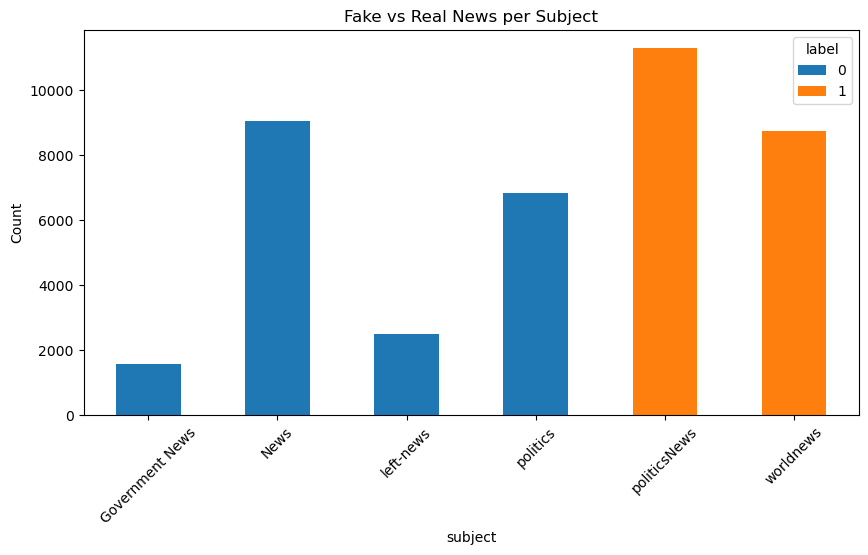

In [29]:
# Graphical visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title('Distribution of Fake vs Real News')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

subject_counts = df['subject'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.title('Number of Articles per Subject')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

subject_label_counts = df.groupby(['subject','label']).size().unstack(fill_value=0)
subject_label_counts.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Fake vs Real News per Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



## Data preprocessing 
    ** Concatenate title and text columns to create a unified text feature for the model. **
    ** Clean the text data by removing special characters, converting to lowercase, and eliminating stop words. **
    ** Check an example of preprocessed text to ensure the cleaning process is effective. **
    ** re preprocess text for shortcuts missing values **
    

In [41]:
#Block 2: Data preprocessing

import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Concatenate title and text
df['content'] = df['title'] + ' ' + df['text']

# Function to find acronyms with dots (e.g., U.S., F.B.I.)
def find_dot_acronyms(df):
    all_text = ' '.join(df['content'].astype(str))
    pattern = r'\b(?:[A-Z]\.){2,}'  # two or more capital letters followed by dots
    acronyms_with_dots = re.findall(pattern, all_text)
    return set(acronyms_with_dots)

# Get acronyms found in the dataset
acronyms = find_dot_acronyms(df)

# Clean text function
def clean_text(text):
    # Replace acronyms with dots by their version without dots
    for abbr in acronyms:
        replacement = abbr.replace('.', '')
        text = text.replace(abbr, replacement)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove all characters that are not letters or spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply cleaning to the content column
df['clean_text'] = df['content'].apply(clean_text)


[nltk_data] Downloading package stopwords to /Users/nazb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# Acronyms found


# Text as string
all_text = ' '.join(df['content'].astype(str))

# Find acronyms with dots
pattern = r'\b(?:[A-Z]\.){2,}'  # two or more letters with dot
acronyms_with_dots = re.findall(pattern, all_text)
print("Acronyms found with dots:", set(acronyms_with_dots))


Acronyms found with dots: {'D.M.', 'M.O.', 'U.S.C.', 'G.O.A.', 'A.N.T.', 'P.C.', 'P.P.', 'N.K.', 'A.G.', 'U.K.', 'N.J.', 'S.J.', 'J.G.', 'D.O.', 'H.P.', 'C.A.', 'E.U.', 'R.C.', 'D.C.C.C.', 'S.A.C.', 'D.H.E.', 'H.E.', 'P.I.', 'R.E.M.', 'C.A.T.', 'S.D.', 'H.C.', 'G.O.P.', 'J.S.', 'V.A.', 'P.T.', 'J.P.', 'A.J.', 'R.B.G.', 'S.C.U.S.', 'H.J.', 'H.S.', 'N.W.A.', 'N.W.', 'B.R.', 'D.H.S.', 'V.L.', 'A.T.', 'G.W.', 'A.B.', 'N.A.A.C.P.', 'P.E.', 'I.S.I.L.', 'V.P.', 'S.W.A.T.', 'D.O.D.', 'T.R.', 'A.K.M.', 'B.I.G.', 'L.L.', 'C.O.C.K.', 'B.T.', 'D.G.', 'A.R.', 'U.S.', 'A.K.', 'U.S.A.', 'I.M.P.A.C.T.S.', 'W.E.B.', 'U.C.', 'N.D.', 'N.N.', 'J.J.', 'M.A.S.', 'I.D.', 'P.A.', 'L.P.', 'K.S.', 'N.Y.P.', 'Y.M.C.A.', 'L.G.', 'N.R.C.C.', 'P.P.S.', 'G.H.W.', 'H.A.', 'O.D.', 'P.G.T.', 'R.J.', 'D.S.M.', 'D.B.', 'H.D.', 'R.I.P.', 'A.N.', 'N.H.', 'D.O.J.', 'G.P.', 'C.F.R.', 'C.V.', 'T.I.', 'N.Y.', 'M.E.', 'B.A.', 'R.L.', 'C.R.', 'U.S.O.U.S.', 'L.A.', 'P.R.', 'J.B.', 'P.M.', 'G.I.', 'F.R.C.P.', 'J.C.', 'P.J.', 'B.L.

In [ ]:
# Check cleaning function
example_text = df.loc[0, 'content']
print("Original text:")
print(example_text)

# Apply cleaning
clean_example = clean_text(example_text)
print("\nCleaned text:")
print(clean_example)



Original text:
As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional inc

In [ ]:
# Check cleaning function
from collections import Counter
import matplotlib.pyplot as plt

# Tokenizar todo el texto limpio en palabras
all_words = ' '.join(df['clean_text']).split()

# Contar las palabras más frecuentes
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)
print("Top 20 most frequent words:")
for word, count in most_common:
    print(f"{word}: {count}")

# Revisar la longitud de cada texto limpio
df['clean_length'] = df['clean_text'].apply(lambda x: len(x.split()))
print("\nStatistics of cleaned text length:")
print(df['clean_length'].describe())


Top 20 most frequent words:
trump: 141831
said: 120696
us: 61453
president: 52858
would: 50073
people: 37433
one: 33249
state: 31056
new: 28631
obama: 27979
house: 27879
reuters: 27486
donald: 27404
also: 26776
clinton: 26433
republican: 25840
states: 24387
government: 24294
year: 22251
white: 21985

Statistics of cleaned text length:
count    39942.000000
mean       235.387462
std        166.868828
min          3.000000
25%        130.000000
50%        217.000000
75%        299.000000
max       4812.000000
Name: clean_length, dtype: float64


# Vectorization
    ** Convert the cleaned text data into numerical format using TF-IDF vectorization. **
    ** Limit the number of features to 20000 to manage computational complexity. **
    
CountVectorizer	Frecuencia	Simple, rápido	No pondera importancia
TF-IDF	Frecuencia + importancia	Destaca palabras informativas, robusto	Dimensionalidad alta
Word embeddings	Vector denso	Captura semántica	Requiere entrenamiento o preentrenados
Sentence embeddings	Vector denso	Contexto completo	Más pesado, más complejo
    ** Split the dataset into training and validation sets to evaluate model performance. **

In [54]:
#Block 3: Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,   # maximum number of features
    ngram_range=(1,2),    # unigrams and bigrams
    min_df=5,             # ignore words that appear in fewer than 5 documents
    stop_words=None       # stopwords already removed
)

# Fit and transform the clean text to TF-IDF features
X = tfidf_vectorizer.fit_transform(df['clean_text'])

# Check the shape of the resulting matrix
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (39942, 20000)


In [55]:
import joblib

# Save the TF-IDF vectorizer for future use
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("TF-IDF vectorizer saved successfully!")


TF-IDF vectorizer saved successfully!


In [56]:
#Block 4: Train-test split
from sklearn.model_selection import train_test_split

# Target variable
y = df['label']

# Split the dataset into training and test sets
# 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shape of each set
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (31953, 20000) (31953,)
Test set shape: (7989, 20000) (7989,)


In [ ]:
#Train and evaluate a Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Measure training time
start_time = time.time()
nb_model.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.4f} seconds")

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Training time: 0.0996 seconds
Test set accuracy: 0.9512

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3989
           1       0.95      0.95      0.95      4000

    accuracy                           0.95      7989
   macro avg       0.95      0.95      0.95      7989
weighted avg       0.95      0.95      0.95      7989


Confusion matrix:
[[3801  188]
 [ 202 3798]]


In [ ]:
#Train and evaluate a Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
# 'saga' solver is efficient for large datasets and supports L2 regularization
lr_model = LogisticRegression(
    solver='saga',    # efficient for large, sparse datasets
    max_iter=1000,    # increase iterations to ensure convergence
    random_state=42
)

# Measure training time
start_time = time.time()
lr_model.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.4f} seconds")

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate model performance
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Test set accuracy: {accuracy_lr:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_lr))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Training time: 0.5576 seconds
Test set accuracy: 0.9875

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3989
           1       0.99      0.99      0.99      4000

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989


Confusion matrix:
[[3929   60]
 [  40 3960]]


In [ ]:
#Save models
import joblib

# Save Multinomial Naive Bayes model
joblib.dump(nb_model, 'naive_bayes_model.pkl')

# Save Logistic Regression model
joblib.dump(lr_model, 'logistic_regression_model.pkl')

print("Both models saved successfully!")


Both models saved successfully!


In [62]:
import pandas as pd
import re
from nltk.corpus import stopwords
import joblib

# ------------------------------
# Load validation dataset
# ------------------------------
validation_df = pd.read_csv('/Users/nazb/VSCode101/project-nlp-challenge/dataset/validation_data.csv')

# ------------------------------
# Load saved models and vectorizer
# ------------------------------
nb_model = joblib.load('naive_bayes_model.pkl')
lr_model = joblib.load('logistic_regression_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# ------------------------------
# Set stopwords
# ------------------------------
stop_words = set(stopwords.words('english'))

# ------------------------------
# Text cleaning function
# ------------------------------
def clean_text(text, acronyms=None):
    text = str(text).lower()
    if acronyms:
        for abbr in acronyms:
            text = text.replace(abbr, abbr.replace('.', ''))
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# ------------------------------
# Preprocess validation data
# ------------------------------
validation_df['content'] = validation_df['title'] + ' ' + validation_df['text']

# Find acronyms with dots
all_text = ' '.join(validation_df['content'].astype(str))
pattern = r'\b(?:[A-Z]\.){2,}'
acronyms = set(re.findall(pattern, all_text))

# Clean text
validation_df['clean_text'] = validation_df['content'].apply(lambda x: clean_text(x, acronyms))

# ------------------------------
# Transform text using TF-IDF
# ------------------------------
X_validation = tfidf_vectorizer.transform(validation_df['clean_text'])

# ------------------------------
# Predict labels with both models
# ------------------------------
validation_df['label_nb'] = nb_model.predict(X_validation)
validation_df['label_lr'] = lr_model.predict(X_validation)

# ------------------------------
# Save predictions to CSV
# ------------------------------
# Naive Bayes
nb_df = validation_df.copy()
nb_df['label'] = nb_df['label_nb']
nb_df[['label', 'title', 'text', 'subject', 'date']].to_csv('validation_predictions_nb.csv', index=False)

# Logistic Regression
lr_df = validation_df.copy()
lr_df['label'] = lr_df['label_lr']
lr_df[['label', 'title', 'text', 'subject', 'date']].to_csv('validation_predictions_lr.csv', index=False)

print("Predictions saved successfully for both models!")

# ------------------------------
# Mini-report: distribution and comparison
# ------------------------------
print("\n--- Distribution of predictions ---")
print("Naive Bayes label counts:")
print(validation_df['label_nb'].value_counts())
print("\nLogistic Regression label counts:")
print(validation_df['label_lr'].value_counts())

# Compare both models
validation_df['agreement'] = validation_df['label_nb'] == validation_df['label_lr']
agreement_count = validation_df['agreement'].sum()
total_count = len(validation_df)
print(f"\nAgreement between models: {agreement_count}/{total_count} ({agreement_count/total_count:.2%})")

# Optional: check disagreements
disagreements = validation_df[validation_df['agreement'] == False][['title', 'label_nb', 'label_lr']]
print(f"\nNumber of disagreements: {len(disagreements)}")
if len(disagreements) > 0:
    print(disagreements.head(5))  # show first 5 examples


Predictions saved successfully for both models!

--- Distribution of predictions ---
Naive Bayes label counts:
label_nb
0    3143
1    1813
Name: count, dtype: int64

Logistic Regression label counts:
label_lr
0    3383
1    1573
Name: count, dtype: int64

Agreement between models: 4638/4956 (93.58%)

Number of disagreements: 318
                                                 title  label_nb  label_lr
179  Family of Australian woman fatally shot wants ...         0         1
212  UK police release new image of jogger in Londo...         0         1
240  Draining the swamp: Hard-hit Everglades town m...         0         1
241  After Irma, a mixed journey home for Florida e...         0         1
258  In Mexican town, women and 'muxes' take charge...         0         1
